In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy import stats
from sklearn.metrics import auc
import sys

sys.path.insert(0, '../Common/')
from MetricUtils import interpolate, average_same_x


In [2]:
modes = {'initial-tune': 'Baseline', 'spire-transfer': 'SPIRE', 'fs-tune': 'FS'}
trials = [0,1,2,3,4,5,6,7]
baseline = 'initial-tune'
corrected_list = ['spire-transfer', 'fs-tune']

In [3]:

ts = np.linspace(0, 1, 101)
for config in [('ap-orig', 'Average Precision - Original Distribution'), ('ap', 'Average Precision - Balanced Distribution'), ('r-gap', 'Recall Gap'), ('h-gap', 'Hallucination Gap'), ('cf-add', 'Probabily prediction changes when we add a patch to a malignant image')]:
    print(config[1])
    print()
    
    out = {}

    for mode in modes:

        agg = []
        for trial in trials:

            with open('./Models/{}/trial{}/results.pkl'.format(mode, trial), 'rb') as f:
                results = pickle.load(f)

            metric = config[0]
            if metric in ['r-gap', 'h-gap']:
                curve_tmp = interpolate(results['recall'], results[metric], ts)
                agg.append(auc(ts, curve_tmp))
            else:
                agg.append(results[metric])
        out[mode] = np.array(agg)

    print(modes[baseline])
    print(np.round(np.mean(out[baseline]), 4), np.round(np.std(out[baseline]), 4))

    for corrected in corrected_list:   
        print(modes[corrected])
        diff = out[corrected] - out[baseline]
        test = stats.ttest_rel(out[corrected], out[baseline])
        print(np.round(np.mean(diff), 4), np.round(np.std(diff), 4), np.round(test.pvalue, 3))
        
    print()
    print()
    

Average Precision - Original Distribution

Baseline
0.7829 0.0316
SPIRE
0.0046 0.0494 0.813
FS
-0.0764 0.0675 0.02


Average Precision - Balanced Distribution

Baseline
0.7095 0.0348
SPIRE
0.0545 0.0237 0.0
FS
-0.0297 0.0381 0.078


Recall Gap

Baseline
0.1122 0.0508
SPIRE
-0.0233 0.0608 0.344
FS
-0.035 0.0681 0.216


Hallucination Gap

Baseline
0.0413 0.0171
SPIRE
-0.0159 0.0104 0.005
FS
-0.0253 0.0154 0.003


Probabily prediction changes when we add a patch to a malignant image

Baseline
0.1806 0.0712
SPIRE
-0.1124 0.0551 0.001
FS
0.0326 0.1234 0.507




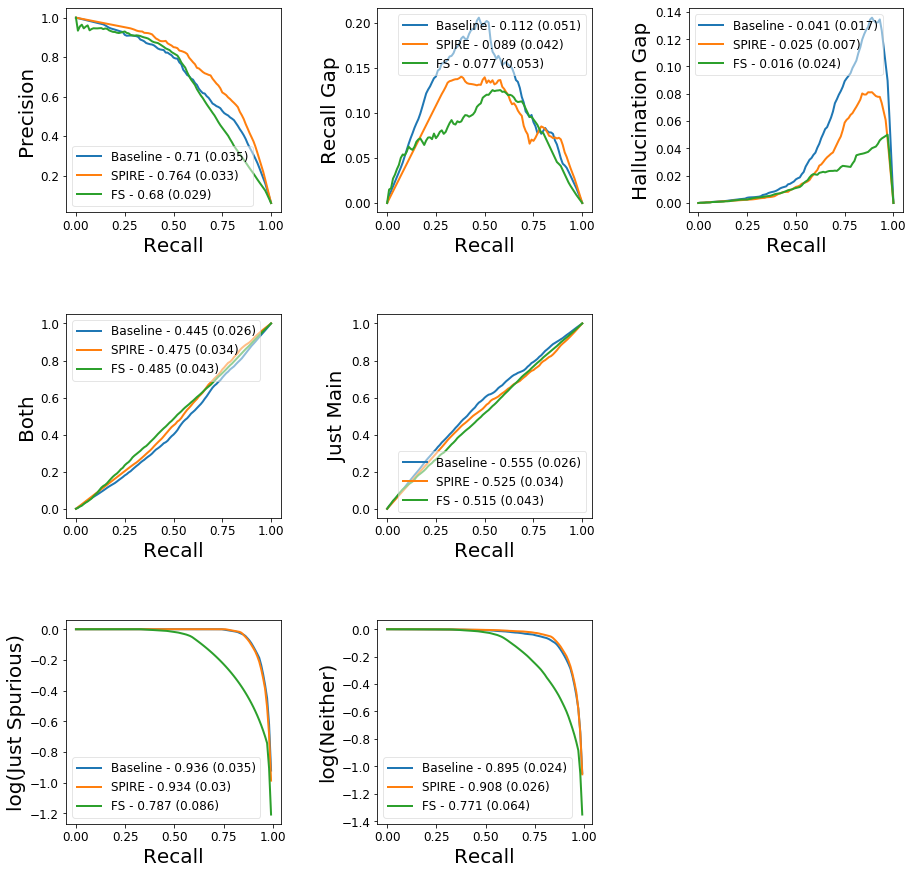

In [4]:

np.seterr(divide = 'ignore') 

mpl.rcParams['font.size'] = 20
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

ts = np.linspace(0, 1, num = 101)

fig, ax_all = plt.subplots(3, 3)
fig.set_figheight(15)
fig.set_figwidth(15)        
fig.subplots_adjust(hspace = 0.5, wspace = 0.45)

pr = {}

for mode in modes:

    values = {'ap': [], 'r-gap': [], 'h-gap': [], 'both': [], 'just_main': [], 'just_spurious': [], 'neither': []} 
    curves = {'ap': [], 'r-gap': [], 'h-gap': [], 'both': [], 'just_main': [], 'just_spurious': [], 'neither': []} 
    for trial in trials:
    
        with open('./Models/{}/trial{}/results.pkl'.format(mode, trial), 'rb') as f:
            results = pickle.load(f)
        
        curve_tmp = interpolate(results['recall'], results['precision'], ts)
        curves['ap'].append(curve_tmp)
        values['ap'].append(auc(ts, curve_tmp))
        
        for name in curves:
            if name != 'ap':
                curve_tmp = interpolate(results['recall'], results[name], ts)
                curves[name].append(curve_tmp)
                values[name].append(auc(ts, curve_tmp))               

    values_avg = {}
    values_std = {}
    curves_avg = {}
    for name in values:
        values_avg[name] = np.round(np.mean(values[name]), 3)
        values_std[name] = np.round(np.std(values[name]), 3)
        curves_avg[name] = average_same_x(ts, curves[name])
        

    pr[mode] = curves_avg['ap']
    
    ax = ax_all[0,0]
    ax.plot(ts, curves_avg['ap'], label = '{} - {} ({})'.format(modes[mode], values_avg['ap'], values_std['ap']))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend()

    ax = ax_all[0,1]
    ax.plot(ts, curves_avg['r-gap'], label = '{} - {} ({})'.format(modes[mode], values_avg['r-gap'], values_std['r-gap']))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Recall Gap')
    ax.legend()

    ax = ax_all[0,2]
    ax.plot(ts, curves_avg['h-gap'], label = '{} - {} ({})'.format(modes[mode], values_avg['h-gap'], values_std['h-gap']))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Hallucination Gap')
    ax.legend()

    ax = ax_all[1,0]
    ax.plot(ts, curves_avg['both'], label = '{} - {} ({})'.format(modes[mode], values_avg['both'], values_std['both']))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Both')
    ax.legend()

    ax = ax_all[1,1]
    ax.plot(ts, curves_avg['just_main'], label = '{} - {} ({})'.format(modes[mode], values_avg['just_main'], values_std['just_main']))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Just Main')
    ax.legend()

    ax = ax_all[2,0]
    ax.plot(ts, np.log10(curves_avg['just_spurious']), label = '{} - {} ({})'.format(modes[mode], values_avg['just_spurious'], values_std['just_spurious']))
    ax.set_xlabel('Recall')
    ax.set_ylabel('log(Just Spurious)')
    ax.legend()

    ax = ax_all[2,1]
    ax.plot(ts, np.log10(curves_avg['neither']), label = '{} - {} ({})'.format(modes[mode], values_avg['neither'], values_std['neither']))
    ax.set_xlabel('Recall')
    ax.set_ylabel('log(Neither)')
    ax.legend()

    ax_all[1,2].set_axis_off()
    ax_all[2,2].set_axis_off()

plt.show()
plt.close()

np.seterr(divide = 'warn');
